# Quantitative Macroeconomics - Homework IV
## Parts I., II.1., II.2., II.3.
Ivana Kaloyanova Ganeva

*December, 2020*

In [1]:
# Preliminary to the preliminaries if package quantecon is missing:
# pip install quantecon

In [4]:
# SOME PRELIMINARIES:
# (loading the necessary libraries)
import pandas as pd
import numpy as np
import scipy as sp
from numpy import vectorize
from itertools import product
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.interpolate import BSpline 
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import quantecon as qe
import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)
np.seterr(divide = 'ignore', invalid = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## I. A simple wealth model
Considering the sequential problem of a household that maximizes over streams of future consumption,
$$
\max_{\{c_t\}_{t=0}^T} \mathbb{E}_0 \sum_{t=0}^T \beta^t u(c_t) \, ,
$$
where $\beta=\dfrac{1}{1+\rho}\,\in\,(0,1)$. Labour supply is inelastic and normalized to one. The budget constraint for this household at period $t$ is 
$$
c_t + a_{t+1} = w_t y_t + (1+r_t)a_t \, ,
$$
where $r_t$ is exogenously given. The individual faces a stochastic endowment process of efficiency units of labor $\{y_t\}_{t=0}^T$ with $y_t \, \in \, Y = \{y_1,y_2,\cdots,y_N\}$. The endowment process is Markov with $\pi(y'|y)$ denoting the probability that tomorrow's endowment is $y'$ if today's endowment is $y$, i.e. $\sum_{y'}\pi(y'|y)=1$.

###  Preferences
Considering two utility functions:
1. Quadratic Utility:
$$
u(c_t) = -\dfrac{1}{2} (c_t - \bar{c})^2 \, ,
$$
where we can set $\bar{c}$ high enough, say 100 times the maximal income, to avoid saturation of any consumer.
2. CRRA Utility:
$$
u(c_t) = \dfrac{c_t^{1-\sigma}-1}{1-\sigma} \, ,
$$
with $\sigma>0$
Making the program code flexible for applying both of these utility functions under different parameter values for $\bar{c}$ and $\sigma$. Noticing that here, a value of $\sigma=1$ yields the log-utility (at the limit, after applying l'Hôpital's rule). 

In [20]:
# function to calculate the preferences, based on the choice of preferences:
def preferences(c_bar, c, pref_type = 'quadratic', sigma = 0.5):
    if pref_type == 'quadratic':
        u = -0.5*(c-c_bar)**2
    elif pref_type == 'CRRA':
        if c >= 0:
            u = (c**(1-sigma)-1)/(1-sigma)
        else:
            u = -10000
    else:
        u = 'Please, select either quadratic or CRRA utility.'
    return u

### Factor prices and subjective discount rate
Assume $r=4\%<\rho=6\%$, hence in the presence of certainty equivalence, agents will like declining consumption profiles, as seen in Macroeconomics II. Also normalizing $w$ to 1. Making the codes flexible to different future parametrizations by including these in a separate chunk of code below.

### Income Process
Assuming a 2-state process, where we let:
$$
Y = \{1-\sigma_y,1+\sigma_y\} \, ,
$$
and we consider the transition matrix of income to be:
\begin{equation}
\begin{pmatrix}
\dfrac{1+\gamma}{2} & \dfrac{1-\gamma}{2}\\
\dfrac{1-\gamma}{2} & \dfrac{1+\gamma}{2}\\
\end{pmatrix} \, .
\end{equation}
This way, the variance of the income process and its persistence are respectively:
$$
Var(y) = \sigma_y^2
$$
and
$$
Corr(y',y) = \dfrac{Cov(y',y)}{\sqrt{Var(y')}\sqrt{Var(y)}} = \gamma \, .
$$

In [26]:
# Model parameters:
r = 0.04 
rho = 0.06
w = 1
gamma = 0.5
sigma_y = 0.2

# Also adding the tolerance for convergence:
eps = 10**(-3)

# Future discount rate:
beta = 1/(1+rho)

# Markov Process transition matrix:
pi = np.array([((1+gamma)/2, (1-gamma)/2),((1-gamma)/2, (1+gamma)/2)])

# Income:
Y = (1 - sigma_y, 1 + sigma_y) # note to self: 
                               # nest this in a function where the user can choose cardinality N, sigma_y etc
c_bar_sat = 100*Y[1] # avoiding saturation as required -> this could be altered

# Assets grid for following period:
A = np.linspace(((-(1+r)/r)*Y[0]), 50, 80) # Replacing with (1+r)/r 
                                           # in order to find solution when borrowing not allowed

### Borrowing constraints
Considering two cases, as in the utility:
1. The natural borrowing constraint
$$
a_{t+1} \geq -\bar{A} = -\dfrac{1+r}{r} y_{min} \, ,
$$
and this constraint ensures that an agent who has borrowed up to the maximal amount and has the worst income shock can repay the interest on their loans and still have non-negative consumption. If the time horizon is finite, use the constraint that agents cannot die in debt, i.e. $a_{T+1}\geq 0$. This implies borrowing constraints for all ages of the form:
$$
a_{t+1} \geq -y_{min} \sum_{s=0}^{T-(t+1)} (1+r)^{-s} \, .
$$
2. $a_{t+1} \geq 0$, preventing borrowing altogether.

## II. Solving the ABHI Model
### II.1. The recursive formulation
Formulating the problem of the agent recursively, i.e. writing down the Bellman equation and deriving the stochastic Euler equation. Using the above information and the usual setting, the recursive formulation of the agent's problem in the simple wealth economy considered reads as:
\begin{align}
V(a,y) = \max_{\bar{A}\leq a' \leq (1+r)a + yw} \left\{u(wy+(1+r)a-a') + \beta \sum_{y'} \pi(y'|y)V'(a',y') - \lambda_a (a'+\bar{A})\right\} \, ,
\end{align}
and the respective First-Order/Complementary slackness/Dual feasibility conditions are:
\begin{equation}
\begin{cases}
\dfrac{\partial V(a,y)}{\partial a'}=0 \Longleftrightarrow u_c(wy+(1+r)a-a')-\lambda_a+\beta\sum_{y'}\pi(y'|y)\dfrac{\partial V'(a',y')}{\partial a'}=0\\
\lambda_a\geq 0\\
\lambda_a(a'+\bar{A})=0
\end{cases} \, .
\end{equation}
Applying the Envelope theorem to substitute with the policy function of $g^a(a,y)$, we can substitute inside the Bellman equation to obtain:
\begin{align}
V(a,y) &= \max_{\bar{A}\leq a' \leq (1+r)a + yw} \left\{u(wy+(1+r)a-a') + \beta \sum_{y'} \pi(y'|y)V'(a',y') - \lambda_a (a'+\bar{A})\right\}\\
&= \max_{\bar{A}\leq a' \leq (1+r)a + yw} \left\{u(wy+(1+r)a-g^a(a,y)) + \beta \sum_{y'} \pi(y'|y)V'(g^a(a,y),y') - \lambda_a (g^a(a,y)+\bar{A})\right\} \, .
\end{align}
Now, since the maximum is obtained at the policy function and hence, $\dfrac{\partial g^a(a,y)}{\partial} = 0$, we can proceed to calculate the first derivative of the value function w.r.t. $a$:
\begin{align}
\dfrac{\partial V(a,y)}{\partial a} &= u_c(wy + (1+r)a - g^a(a,y))(1+r) - u_c(wy+(1+r)a - g^a(a,y))\dfrac{\partial g^a(a,y)}{\partial a} - \lambda_a \dfrac{\partial g^a(a,y)}{\partial a} + \beta \sum_{y'} \pi(y'|y) \dfrac{V(g^a(a,y))}{\partial g^a(a,y)}\cdot\dfrac{\partial g^a(a,y)}{\partial a}\\
&= u_c(c)(1+r) \, .
\end{align}
Consequently, the first-order condition becomes equivalent to:
$$
u_c(c) = - \lambda_a + \beta(1+r)\sum_{y'} \pi(y'|y) u_c(c') \, ,
$$
and thus,
\begin{equation}
\left\{ \begin{array}{ll} U_c(c) \geq \frac{1+r}{1+\rho}\sum_{y'}\pi_{y'|y} u_c(c')) & \textrm{if $a' = \bar{A}$}\\ U_c(c) = \frac{1+r}{1+\rho} \sum_{y'}\pi_{y'|y} u_c(c')) & \textrm{if $a' \geq \bar{A}$} \end{array} \right.  \, .
\end{equation}

### II.2. The infinitely-lived households economy
For $T=\infty$ write a computer program that computes the value function $v(a,y)$ and the decision rules $a'(a,y)$ and $c(a,y)$ for a given choice of utility function as well as a given parametrization of the income process. Solve this economy using both discrete and continuous methods to approximate functions $v,a'$ and $c$. That is, first, discretize state space
$$
A\times Y  = \{(a,y):a\,\in\,A \quad \text{and} \quad y\,\in\,Y\} \, ,
$$
where $A = \{a_1,\cdots,a_n\}$ and $Y=\{y_1,y_2\}$ with $a_1=-A$ and use value function or Euler equation methods. Then, using the continuous method of piecewise linear splines.

In [41]:
# Running the code for quadratic utility (could be changed within the argument of the preferences function, though):

# Discrete method for infinitely-lived agents
a_y = list(product(Y, A, A))
a_y = np.array(a_y)

y = a_y[:,0]
a_i = a_y[:,1]; a_j = a_y[:,2]

c_s = y + (1+r)*a_i - a_j

# Obtaining the utility:
Utility = np.reshape(preferences(c_bar_sat, c_s, pref_type = 'quadratic', sigma = 0.5), (1, 12800))
Utility = np.reshape(Utility, (160, 80))

V_init = np.zeros(160) # initial guess for V

# obtaining W:
def W1(A):   
    return pi[0, 0]*(-0.5*(Y[0] + (1+r)*A - A - c_bar_sat)**2)/(1-beta) + \
           pi[0, 1]*(-0.5*(Y[1] + (1+r)*A - A - c_bar_sat)**2)/(1-beta)
def W2(A):
    return pi[1, 0]*(-0.5*(Y[0] + (1+r)*A - A - c_bar_sat)**2)/(1-beta) + \
           pi[1, 1]*(-0.5*(Y[1] + (1+r)*A - A - c_bar_sat)**2)/(1-beta) # note to self: adjust this for CRRA
                                                                        # wrapping all in a fnct

W1 = np.transpose(np.tile(np.reshape(W1(A), (80,1)), 80))
W2 = np.transpose(np.tile(np.reshape(W2(A), (80,1)), 80))

W = np.reshape([W1, W2], (160,80))

# obtaining X:
X = Utility + beta*W

V_it = np.amax(X, axis = 1) # next guess for V
V_diff = V_init - V_it

# Iterating in the same manner as above until convergence is met (see eps in the parameters chunk of code):
count = 0
while np.any(abs(V_diff) > eps):
    V_ss = V_it
    V_init = np.array([V_ss[0:80], V_ss[80:]])
    
    def W1(V_init):
        return pi[0,0]*V_init[0,:] + pi[0,1]*V_init[1,:]
    def W2(V_init):
        return pi[1,0]*V_init[0,:] + pi[1,1]*V_init[1,:]
    
    W1 = np.reshape(np.tile(np.reshape(W1(V_init), (1,80)), 80), (80,80))
    W2 = np.reshape(np.tile(np.reshape(W2(V_init), (1,80)), 80), (80,80))

    W = np.reshape([W1, W2], (160,80))
    
    X = Utility + beta*W
    
    V_it = np.amax(X, axis = 1)
    V_diff = V_ss - V_it
    
    count += 1
    
# Once convergence is obtained, X will be as desired, and the value functions for the 2 states in the economy are:
V_y_l = V_it[0:80]; V_y_h = V_it[80:]

# The policy function then reads as:
g = np.argmax(X, axis = 1)

# First 45 periods, as desired:
a_opt_y_l = A[g[0:80]] # optimal assets levels for whenever y is low
a_opt_y_h = A[g[80:]]  # optimal assets levels for whenever y is high

c_y_l = Y[0]*np.ones(80) + (1+r)*A - a_opt_y_l # consumption levels for whenever y is low
c_y_h = Y[1]*np.ones(80) + (1+r)*A - a_opt_y_h # consumption levels for whenever y is low

# Imposing the non-negativity condition:
c_y_l = [max(i,0) for i in c_y_l]; c_y_h = [max(i,0) for i in c_y_h]; 

- Plotting the value function and the optimal policies on $a$ and $c$:
    - (observing the kinks as mentioned)

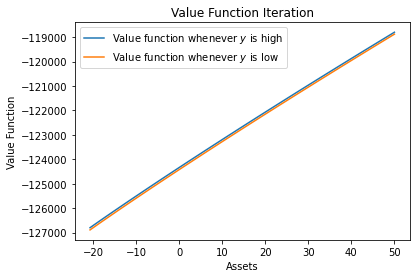

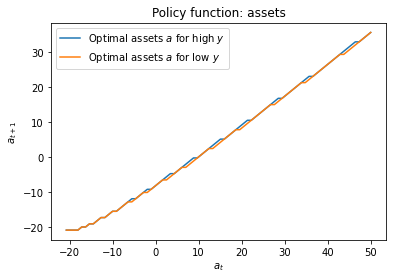

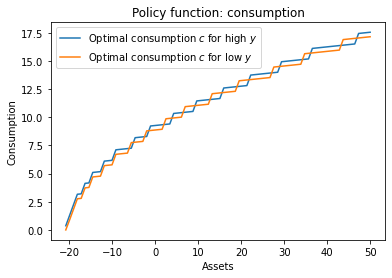

In [40]:
plt.figure()
plt.plot(A, V_y_h, label = 'Value function whenever $y$ is high')
plt.plot(A, V_y_l, label = 'Value function whenever $y$ is low')
plt.title('Value Function Iteration')
plt.legend()
plt.ylabel('Value Function')
plt.xlabel('Assets')
plt.show()
    
plt.figure()
plt.plot(A, a_opt_y_h, label = 'Optimal assets $a$ for high $y$')
plt.plot(A, a_opt_y_l, label = 'Optimal assets $a$ for low $y$')
plt.title('Policy function: assets')
plt.legend()
plt.ylabel('$a_{t+1}$')
plt.xlabel('$a_t$')
plt.show()

plt.figure()
plt.plot(A, c_y_h, label = 'Optimal consumption $c$ for high $y$')
plt.plot(A, c_y_l, label = 'Optimal consumption $c$ for low $y$')
plt.title('Policy function: consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()

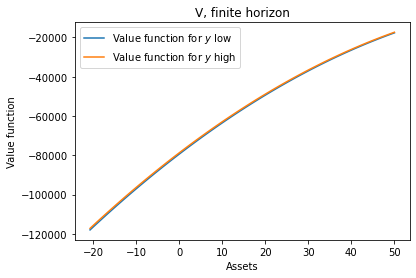

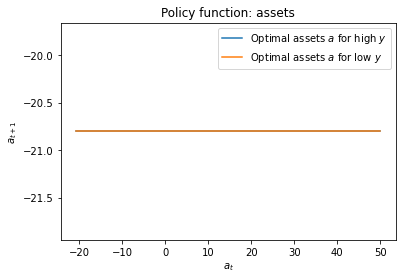

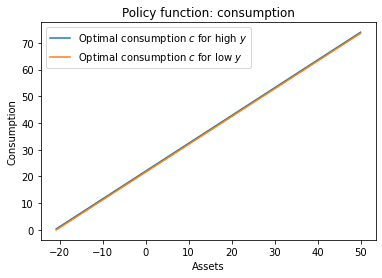

In [46]:
# Backwards iteration method for the life-cycle economy:

# Re-initializing
W = np.zeros((160, 80))
count = 0

while count < 45:
    W = np.reshape(np.amax((Utility + beta*W), axis = 1), (160,1))*np.ones((160,80))    
    count += 1

plt.plot(A, W[0:80, 0], label = 'Value function for $y$ low')
plt.plot(A, W[80:, 0], label = 'Value function for $y$ high')
plt.legend()
plt.title('V, finite horizon')
plt.ylabel('Value function')
plt.xlabel('Assets')
plt.show()

X = Utility + beta*W
g = np.argmax(X, axis = 1) # as before

a_opt_y_l = A[g[0:80]]     # optimal decision of assets given y_l
a_opt_y_h = A[g[80:]]      # optimal decision of assets given y_h

c_y_l = Y[0]*np.ones(80) + (1+r)*A - a_opt_y_l
c_y_h = Y[1]*np.ones(80) + (1+r)*A - a_opt_y_h

# Imposing the non-negativity condition once again:
c_y_l = [max(i,0) for i in c_y_l]; c_y_h = [max(i,0) for i in c_y_h]; 

plt.figure()
plt.plot(A, a_opt_y_h, label = 'Optimal assets $a$ for high $y$')
plt.plot(A, a_opt_y_l, label = 'Optimal assets $a$ for low $y$')
plt.title('Policy function: assets')
plt.legend()
plt.ylabel('$a_{t+1}$')
plt.xlabel('$a_t$')
plt.show()

plt.figure()
plt.plot(A, c_y_h, label = 'Optimal consumption $c$ for high $y$')
plt.plot(A, c_y_l, label = 'Optimal consumption $c$ for low $y$')
plt.title('Policy function: consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()